In [1]:
!pip install ipython-autotime
%load_ext autotime

time: 378 µs (started: 2025-03-11 04:27:18 +00:00)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

time: 6.4 s (started: 2025-03-11 04:27:18 +00:00)


# Data Gathering

In [20]:
import pandas as pd
import yfinance as yf

# Ambil data dari Yahoo Finance untuk masing-masing ticker
gold_futures = yf.download('GC=F', start='2005-01-01', end='2025-03-10')['Close']
usd_idr_data = yf.download('IDR=X', start='2005-01-01', end='2025-03-10')['Close']
visa_data = yf.download('V', start='2005-01-01', end='2025-03-10')['Close']
apple_data = yf.download('AAPL', start='2005-01-01', end='2025-03-10')['Close']
msft_data = yf.download('MSFT', start='2005-01-01', end='2025-03-10')['Close']
nvda_data = yf.download('NVDA', start='2005-01-01', end='2025-03-10')['Close']  # Tambahkan NVIDIA

# Gabungkan data ke dalam satu DataFrame dengan outer join
data = pd.concat([gold_futures, usd_idr_data, visa_data, apple_data, msft_data, nvda_data], axis=1, join='outer')

# Beri nama kolom
data.columns = ['Gold_Futures_USD', 'USD_IDR', 'Visa_USD', 'Apple_USD', 'MSFT_USD', 'NVDA_USD']

# Forward fill untuk menangani nilai kosong (jika ada)
data.ffill(inplace=True)

# Konversi harga emas dari USD/ons ke Rupiah/gram
data['Gold_Futures_IDR_per_gram'] = (data['Gold_Futures_USD'] * data['USD_IDR']) / 31.1035

# Konversi semua saham AS ke Rupiah
data['Visa_IDR'] = data['Visa_USD'] * data['USD_IDR']
data['Apple_IDR'] = data['Apple_USD'] * data['USD_IDR']
data['MSFT_IDR'] = data['MSFT_USD'] * data['USD_IDR']
data['NVDA_IDR'] = data['NVDA_USD'] * data['USD_IDR']

# Hapus kolom harga saham dalam USD dan harga emas dalam USD
data = data.drop(['Gold_Futures_IDR_per_gram','Gold_Futures_USD', 'Visa_USD', 'Apple_USD', 'MSFT_USD', 'MSFT_IDR','NVDA_USD', 'USD_IDR'], axis=1)

# Tampilkan DataFrame
print(data.head())


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

            Visa_IDR    Apple_IDR     NVDA_IDR
Date                                          
2005-01-03       NaN  8839.935357  1672.791772
2005-01-04       NaN  8934.378557  1594.699819
2005-01-05       NaN  9004.666868  1608.181951
2005-01-06       NaN  9033.699612  1596.481881
2005-01-07       NaN  9679.049927  1563.907758
time: 933 ms (started: 2025-03-11 04:29:10 +00:00)


In [33]:
df = data.loc['2015-01-01':]
df

,Visa_IDR,Apple_IDR,NVDA_IDR
Date,,,
2015-01-01,7.559962e+05,3.042241e+05,5.962359e+03
2015-01-02,7.641272e+05,3.013301e+05,5.986148e+03
2015-01-05,7.526879e+05,2.949683e+05,5.927789e+03
2015-01-06,7.565267e+05,2.984236e+05,5.814852e+03
2015-01-07,7.672698e+05,3.028478e+05,5.804297e+03
...,...,...,...
2025-03-03,5.977990e+06,3.932732e+06,1.884499e+06
2025-03-04,5.794606e+06,3.881331e+06,1.908175e+06
2025-03-05,5.776546e+06,3.861186e+06,1.921257e+06


time: 18.6 ms (started: 2025-03-11 04:38:53 +00:00)


# Fama-French


In [205]:
import statsmodels.api as sm
from pandas_datareader import DataReader

time: 626 µs (started: 2025-03-11 06:47:07 +00:00)


In [206]:
# # Gunakan link RAW dari GitHub

# url = 'https://raw.githubusercontent.com/alwanrahmanas/markowitz/refs/heads/main/F-F_Research_Data_5_Factors_2x3_daily.CSV'

# # Baca CSV dari GitHub
# ff5 = pd.read_csv(url)

# # Tampilkan 5 baris pertama
# print(ff5.head())

time: 282 µs (started: 2025-03-11 06:47:07 +00:00)


In [207]:
# # Ubah 'date' menjadi string lalu konversi ke datetime
# ff5['date'] = pd.to_datetime(ff5['date'].astype(str), format='%Y%m%d')

# # Jadikan 'date' sebagai index
# ff5.set_index('date', inplace=True)

# # Tampilkan hasil
# print(ff5.head())

time: 302 µs (started: 2025-03-11 06:47:07 +00:00)


In [208]:
# Hitung return harian
returns = df.pct_change().dropna()
print("Return Harian:\n", returns)
# Unduh data Fama-French 3-Factor
ff_data = DataReader('F-F_Research_Data_Factors', 'famafrench', start='2010-01-01')[0]
ff_data = ff_data / 100  # Konversi persentase ke desimal

# Konversi indeks ff_data dari PeriodIndex ke DatetimeIndex
ff_data.index = ff_data.index.to_timestamp()

# Sesuaikan frekuensi data Fama-French dengan data harian
ff_data = ff_data.resample('D').ffill()

# Reindex ff_data agar sesuai dengan indeks returns
ff_data = ff_data.reindex(returns.index, method='ffill')

Return Harian:
             Visa_IDR  Apple_IDR  NVDA_IDR
Date                                     
2015-01-02  0.010755  -0.009513  0.003990
2015-01-05 -0.014970  -0.021112 -0.009749
2015-01-06  0.005100   0.011714 -0.019052
2015-01-07  0.014200   0.014825 -0.001815
2015-01-08  0.020230   0.045408  0.044597
...              ...        ...       ...
2025-03-03 -0.004364  -0.017639 -0.088684
2025-03-04 -0.030677  -0.013070  0.012563
2025-03-05 -0.003117  -0.005190  0.006856
2025-03-06 -0.030717  -0.008450 -0.063711
2025-03-07  0.006652   0.019215  0.022506

[2655 rows x 3 columns]
time: 409 ms (started: 2025-03-11 06:47:07 +00:00)


<ipython-input-208-d52c6419fe6f>:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_data = DataReader('F-F_Research_Data_Factors', 'famafrench', start='2010-01-01')[0]
<ipython-input-208-d52c6419fe6f>:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_data = DataReader('F-F_Research_Data_Factors', 'famafrench', start='2010-01-01')[0]


## Beta faktor

In [209]:
# Fungsi untuk menghitung beta menggunakan regresi rolling
def calculate_fama_french_betas(asset_excess_returns, ff_data, window=252*4):  # 3 tahun rolling window
    betas = []
    for i in range(window, len(asset_excess_returns)):
        X = ff_data[['Mkt-RF', 'SMB', 'HML']].iloc[i-window:i]
        y = asset_excess_returns.iloc[i-window:i]
        X = sm.add_constant(X)  # Tambahkan intercept
        model = sm.OLS(y, X).fit()
        betas.append(model.params)

    return pd.DataFrame(betas, index=asset_excess_returns.index[window:])

# Hitung beta rolling untuk setiap aset
beta_results = {}
for asset in returns.columns:
    beta_results[asset] = calculate_fama_french_betas(excess_returns[asset], ff_data)

# Tampilkan hasil beta terakhir
print("\nBeta Faktor untuk Setiap Aset (Rolling 5 Tahun Terakhir):")
for asset, betas in beta_results.items():
    last_beta = betas.iloc[-1]
    print(f"{asset}: Beta Market = {last_beta['Mkt-RF']:.2f}, Beta SMB = {last_beta['SMB']:.2f}, Beta HML = {last_beta['HML']:.2f}")



Beta Faktor untuk Setiap Aset (Rolling 5 Tahun Terakhir):
Visa_IDR: Beta Market = 0.03, Beta SMB = -0.01, Beta HML = 0.01
Apple_IDR: Beta Market = 0.04, Beta SMB = 0.00, Beta HML = -0.02
NVDA_IDR: Beta Market = 0.10, Beta SMB = -0.01, Beta HML = -0.05
time: 19.1 s (started: 2025-03-11 06:47:08 +00:00)



Beta Faktor untuk Setiap Aset (Rolling 5 Tahun Terakhir):
Visa_IDR: Beta Market = 0.03, Beta SMB = -0.02, Beta HML = 0.01
Apple_IDR: Beta Market = 0.05, Beta SMB = 0.01, Beta HML = -0.02
NVDA_IDR: Beta Market = 0.10, Beta SMB = -0.03, Beta HML = -0.04
time: 19.2 s (started: 2025-03-11 06:10:38 +00:00)

## FF 5-factor expected return

In [210]:
# Parameter bobot eksponensial
lambda_factor = 0.98

# Fungsi untuk menghitung rata-rata eksponensial
def exp_weighted_average(data, lambda_factor=lambda_factor):
    data = data.dropna()  # Pastikan tidak ada NaN sebelum perhitungan
    weights = np.array([(1 - lambda_factor) * lambda_factor**i for i in range(len(data))])
    weights = weights[::-1]  # Bobot terbaru lebih besar
    return np.sum(weights * data) / np.sum(weights)

# Pilih rolling window 10 tahun (252 hari trading per tahun)
rolling_window = 252 * 4

# DataFrame untuk menyimpan expected return per rolling window
expected_returns_ff_ewma = pd.DataFrame(index=ff_data.index, columns=returns.columns)

# Looping untuk setiap rolling window
for i in range(rolling_window, len(ff_data)):
    # Ambil subset data 10 tahun terakhir
    ff_window = ff_data.iloc[i-rolling_window:i]

    # Hitung rata-rata premi faktor dengan bobot eksponensial
    market_premium = exp_weighted_average(ff_window['Mkt-RF'])
    smb_premium = exp_weighted_average(ff_window['SMB'])
    hml_premium = exp_weighted_average(ff_window['HML'])
    rf = exp_weighted_average(ff_window['RF'])

    # Hitung expected return untuk setiap aset
    for asset in returns.columns:
        betas = beta_results[asset].iloc[i-rolling_window]  # Ambil beta terakhir
        expected_return = rf + betas['Mkt-RF'] * market_premium + betas['SMB'] * smb_premium + betas['HML'] * hml_premium
        expected_returns_ff_ewma.loc[ff_data.index[i], asset] = expected_return

# Ambil expected return terbaru
expected_returns_ff = expected_returns_ff_ewma.iloc[-1]

# Tampilkan hasil
print("\n📈 Expected Return (Fama-French 3-Factor dengan Bobot Eksponensial):")
for asset, ret in expected_returns_ff.items():
    print(f"   {asset}: {ret:.2%}")


📈 Expected Return (Fama-French 3-Factor dengan Bobot Eksponensial):
   Visa_IDR: 0.33%
   Apple_IDR: 0.34%
   NVDA_IDR: 0.34%
time: 5.04 s (started: 2025-03-11 06:47:27 +00:00)


# Markowitz

<ipython-input-211-dea139d02e1e>:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  returns = df.pct_change().fillna(method='ffill').dropna()



📌 Portofolio Risiko Minimum (MVP):
   Visa_IDR: 66.18%
   Apple_IDR: 33.82%
   NVDA_IDR: 0.00%
   Expected Return (Annual): 84.91%
   Risk (Standard Deviation, Annual): 25.08%


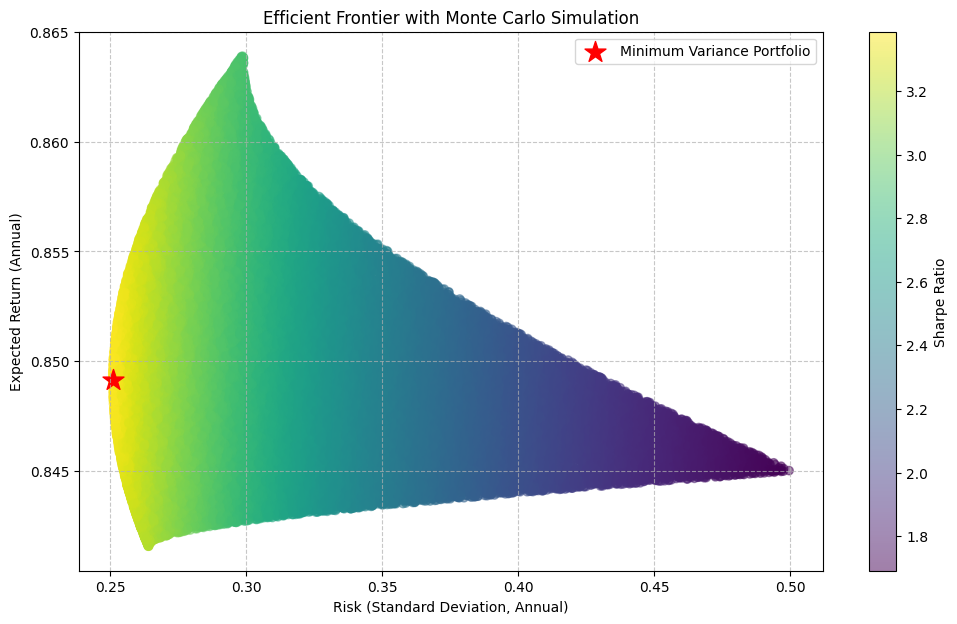

time: 27.6 s (started: 2025-03-11 06:47:54 +00:00)


In [211]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 🟢 1. Hitung return harian dengan handling NaN yang benar
returns = df.pct_change().fillna(method='ffill').dropna()

# 🟢 2. Hitung return ekspektasi dan matriks kovarians
expected_returns = expected_returns_ff
cov_matrix = returns.cov()

# 🟢 3. Fungsi untuk menghitung risiko portofolio (standard deviation)
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(weights.T @ cov_matrix @ weights)

# 🟢 4. Optimasi untuk menemukan Minimum Variance Portfolio (MVP)
num_assets = len(expected_returns)
init_guess = np.ones(num_assets) / num_assets  # Bobot awal (rata)
bounds = [(0, 1) for _ in range(num_assets)]  # Setiap aset antara 0% - 100%
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # Total bobot harus 100%

# Optimasi dengan SLSQP untuk meminimalkan risiko
optimal_result = minimize(
    portfolio_volatility, init_guess, args=(cov_matrix,),
    method='SLSQP', bounds=bounds, constraints=constraints
)
optimal_weights = optimal_result.x

# 🟢 5. Hitung return dan risiko portofolio MVP
min_var_return = np.sum(optimal_weights * expected_returns) * 252  # Skala tahunan
min_var_risk = portfolio_volatility(optimal_weights, cov_matrix) * np.sqrt(252)  # Skala tahunan

# 🟢 6. Cetak hasil MVP
print("\n📌 Portofolio Risiko Minimum (MVP):")
for asset, weight in zip(df.columns, optimal_weights):
    print(f"   {asset}: {weight:.2%}")
print(f"   Expected Return (Annual): {min_var_return:.2%}")
print(f"   Risk (Standard Deviation, Annual): {min_var_risk:.2%}")

# 🟢 7. Monte Carlo Simulation untuk Efficient Frontier
num_portfolios = 50000
risk_list = []
return_list = []
weights_list = []

for _ in range(num_portfolios):
    weights = np.random.dirichlet(np.ones(num_assets), size=1)[0]
    port_return = np.sum(weights * expected_returns) * 252  # Skala tahunan
    port_risk = portfolio_volatility(weights, cov_matrix) * np.sqrt(252)  # Skala tahunan

    return_list.append(port_return)
    risk_list.append(port_risk)
    weights_list.append(weights)

# 🟢 8. Plot Efficient Frontier dengan Monte Carlo Simulation
plt.figure(figsize=(12, 7))
plt.scatter(risk_list, return_list, c=np.array(return_list)/np.array(risk_list), cmap='viridis', marker='o', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(min_var_risk, min_var_return, color='red', marker='*', s=250, label='Minimum Variance Portfolio')
plt.xlabel('Risk (Standard Deviation, Annual)')
plt.ylabel('Expected Return (Annual)')
plt.title('Efficient Frontier with Monte Carlo Simulation')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# Sharpe Ratio

In [212]:
# import matplotlib.pyplot as plt

# # Asumsikan `df` adalah dfFrame yang sudah ada
# plt.figure(figsize=(10, 6))  # Atur ukuran plot
# plt.plot(df.index, df['Gold_Futures_IDR_per_gram'], label='Harga Emas (IDR/gram)', color='gold', linewidth=2)

# # Atur judul dan label
# plt.title('Harga Emas dalam IDR/gram', fontsize=16)
# plt.xlabel('Tanggal', fontsize=12)
# plt.ylabel('Harga (IDR/gram)', fontsize=12)
# plt.legend(loc='upper left', fontsize=12)
# plt.grid(True, linestyle='--', alpha=0.7)  # Tambahkan grid

# # Tampilkan plot
# plt.show()

time: 412 µs (started: 2025-03-11 06:48:21 +00:00)


In [213]:
df.columns

Index(['Visa_IDR', 'Apple_IDR', 'NVDA_IDR'], dtype='object')

time: 2.16 ms (started: 2025-03-11 06:48:21 +00:00)


In [214]:
expected_returns

,2025-03-07
Visa_IDR,0.003339
Apple_IDR,0.003429
NVDA_IDR,0.003353


time: 9.18 ms (started: 2025-03-11 06:48:21 +00:00)


In [215]:
expected_returns_ff

,2025-03-07
Visa_IDR,0.003339
Apple_IDR,0.003429
NVDA_IDR,0.003353


time: 4.61 ms (started: 2025-03-11 06:48:21 +00:00)


<ipython-input-216-ebb22b381822>:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  returns = df.pct_change().fillna(method='ffill').dropna()
Running Monte Carlo Simulation: 100%|██████████| 10000/10000 [00:05<00:00, 1925.04it/s]


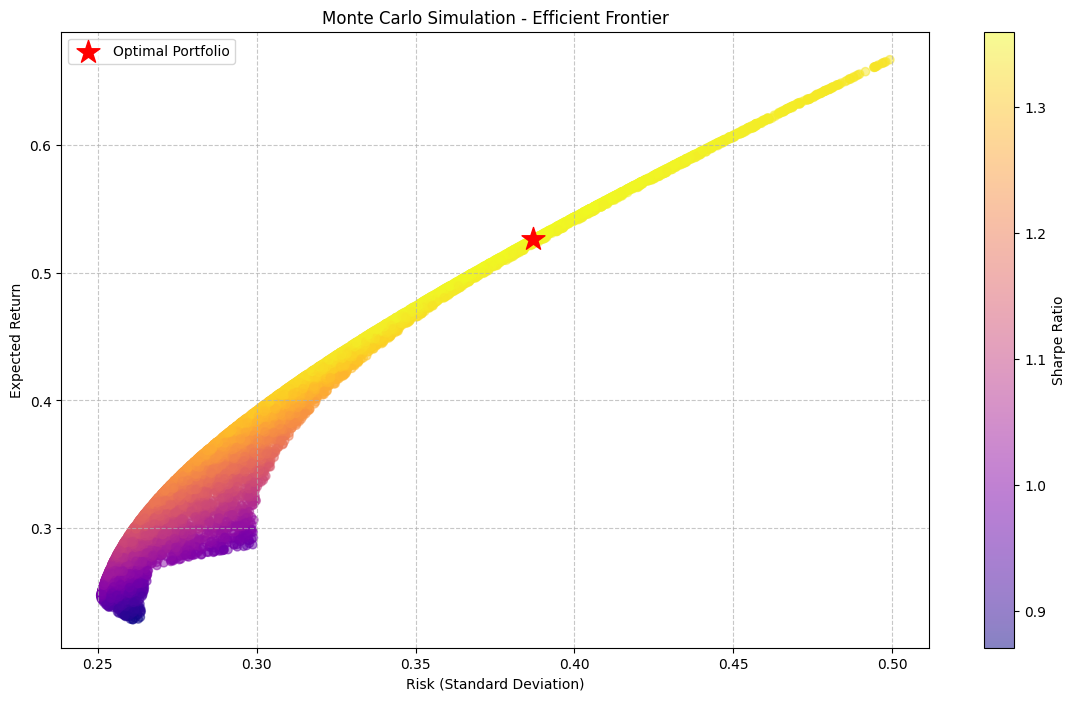


📌 Portofolio Optimal (Maksimum Sharpe Ratio):
   Visa_IDR: 13.61%
   Apple_IDR: 21.46%
   NVDA_IDR: 64.93%
   Expected Return: 52.62%
   Annual Expected Return: 52.62%
   Risk (Standard Deviation): 38.71%
   Sharpe Ratio: 1.36
time: 5.78 s (started: 2025-03-11 06:48:21 +00:00)


In [216]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tqdm import tqdm  # Import tqdm untuk progress bar

# Hitung return harian dengan menangani NaN lebih baik
returns = df.pct_change().fillna(method='ffill').dropna()

# Hitung return ekspektasi tahunan dan matriks kovarians
expected_returns = returns.mean()
cov_matrix = returns.cov()

# Monte Carlo Simulation
num_assets = len(expected_returns)
num_portfolios = 10000  # Jumlah simulasi Monte Carlo

results = np.zeros((4, num_portfolios))  # [Return, Risiko, Sharpe Ratio, Bobot]
weights_list = []

# Gunakan tqdm untuk progress bar
for i in tqdm(range(num_portfolios), desc="Running Monte Carlo Simulation"):
    weights = np.random.dirichlet(np.ones(num_assets), size=1)[0]  # Bobot portofolio
    weights_list.append(weights)

    port_return = np.sum(weights * expected_returns) * 252  # Skala ke tahunan
    port_risk = np.sqrt(weights.T @ cov_matrix @ weights * 252)  # Skala ke tahunan
    sharpe_ratio = port_return / port_risk if port_risk != 0 else 0  # Hindari div/0

    results[0, i] = port_return
    results[1, i] = port_risk
    results[2, i] = sharpe_ratio

# Mencari portofolio optimal (Maksimum Sharpe Ratio)
max_sharpe_idx = np.argmax(results[2])
optimal_weights = weights_list[max_sharpe_idx]

# Hitung expected return tahunan untuk portofolio optimal
expected_return_optimal = np.sum(optimal_weights * expected_returns) * 252

# Visualisasi Monte Carlo Simulation
plt.figure(figsize=(14, 8))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='plasma', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(results[1, max_sharpe_idx], results[0, max_sharpe_idx], color='red', marker='*', s=300, label='Optimal Portfolio')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Monte Carlo Simulation - Efficient Frontier')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Output bobot optimal
print("\n📌 Portofolio Optimal (Maksimum Sharpe Ratio):")
for asset, weight in zip(df.columns, optimal_weights):
    print(f"   {asset}: {weight:.2%}")
print(f"   Expected Return: {results[0, max_sharpe_idx]:.2%}")
print(f"   Annual Expected Return: {expected_return_optimal:.2%}")
print(f"   Risk (Standard Deviation): {results[1, max_sharpe_idx]:.2%}")
print(f"   Sharpe Ratio: {results[2, max_sharpe_idx]:.2f}")



# Sharpe Ratio with T-Tails

In [217]:
expected_returns

,0
Visa_IDR,0.000895
Apple_IDR,0.001138
NVDA_IDR,0.002652


time: 6.78 ms (started: 2025-03-11 06:48:27 +00:00)


In [218]:
expected_returns_ff = pd.Series(expected_returns_ff)
expected_returns_ff

,2025-03-07
Visa_IDR,0.003339
Apple_IDR,0.003429
NVDA_IDR,0.003353


time: 7.68 ms (started: 2025-03-11 06:48:27 +00:00)


<ipython-input-219-4e8913a24d55>:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  returns = df.pct_change().fillna(method='ffill').dropna()
Running Monte Carlo Simulation with Student's T: 100%|██████████| 1000000/1000000 [09:54<00:00, 1682.98it/s]


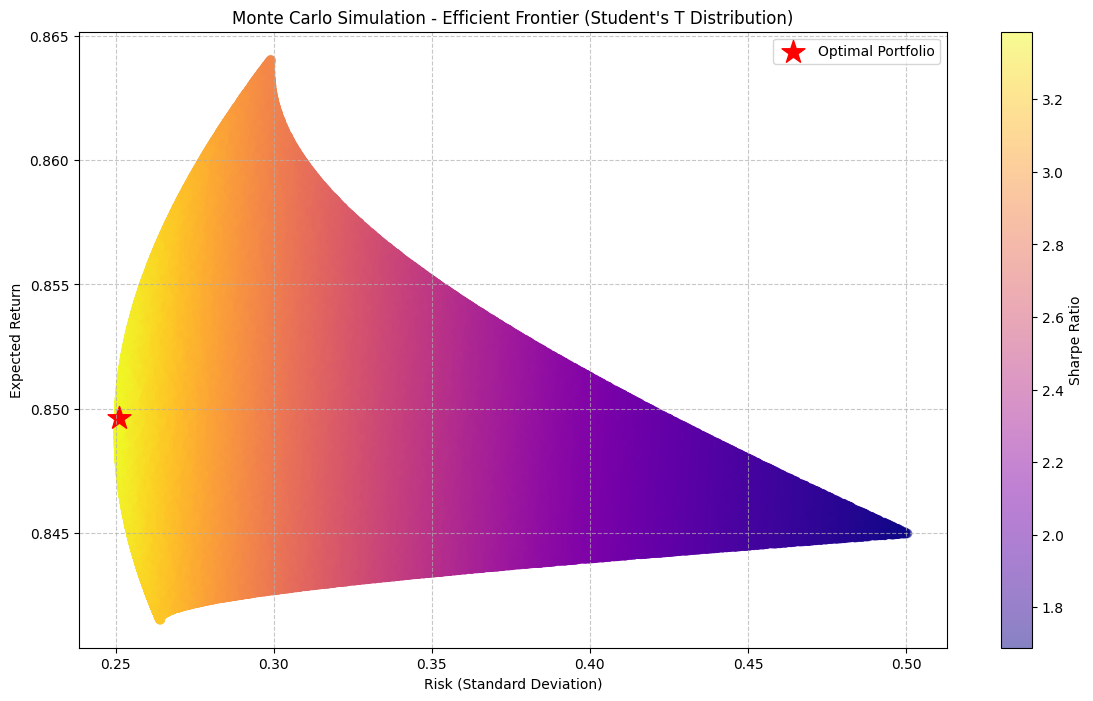


📌 Portofolio Optimal (Maksimum Sharpe Ratio) dengan Distribusi Student's T:
   Visa_IDR: 63.90%
   Apple_IDR: 36.09%
   NVDA_IDR: 0.00%
   Expected Return: 84.97%
   Risk (Standard Deviation): 25.09%
   Sharpe Ratio: 3.39
time: 10min 23s (started: 2025-03-11 06:48:27 +00:00)


In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t
from tqdm import tqdm  # Import tqdm untuk progress bar


# Hitung return harian
returns = df.pct_change().fillna(method='ffill').dropna()

# Hitung matriks kovarians (skala tahunan)
cov_matrix = returns.cov() * 252
expected_returns = expected_returns_ff.copy()
# Monte Carlo Simulation dengan Student's T Distribution
num_assets = len(expected_returns)
num_portfolios = 1000000  # Jumlah simulasi Monte Carlo
df_t = 5  # Derajat kebebasan untuk distribusi Student's T (mengontrol ekor tebal)

results = np.zeros((4, num_portfolios))
max_sharpe = -np.inf
optimal_weights = None

for i in tqdm(range(num_portfolios), desc="Running Monte Carlo Simulation with Student's T"):
    raw_weights = np.abs(t.rvs(df_t, size=num_assets))
    weights = raw_weights / np.sum(raw_weights)

    port_return = np.sum(weights * expected_returns) * 252
    port_risk = np.sqrt(weights.T @ cov_matrix @ weights)
    sharpe_ratio = port_return / (port_risk + 1e-6)

    results[0, i] = port_return
    results[1, i] = port_risk
    results[2, i] = sharpe_ratio

    if sharpe_ratio > max_sharpe:
        max_sharpe = sharpe_ratio
        optimal_weights = weights.copy()  # Gunakan .copy() agar tidak tertimpa

# Validasi hasil
if optimal_weights is None:
    raise ValueError("Tidak ada portofolio yang valid ditemukan dalam simulasi Monte Carlo.")

# Visualisasi Monte Carlo Simulation
plt.figure(figsize=(14, 8))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='plasma', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(results[1, np.argmax(results[2, :])], results[0, np.argmax(results[2, :])],
            color='red', marker='*', s=300, label='Optimal Portfolio')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title("Monte Carlo Simulation - Efficient Frontier (Student's T Distribution)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Output bobot optimal
print("\n📌 Portofolio Optimal (Maksimum Sharpe Ratio) dengan Distribusi Student's T:")
for asset, weight in zip(df.columns, optimal_weights):
    print(f"   {asset}: {weight:.2%}")
print(f"   Expected Return: {results[0, np.argmax(results[2, :])]:.2%}")
print(f"   Risk (Standard Deviation): {results[1, np.argmax(results[2, :])]:.2%}")
print(f"   Sharpe Ratio: {results[2, np.argmax(results[2, :])]:.2f}")

In [220]:
expected_returns_ff

,2025-03-07
Visa_IDR,0.003339
Apple_IDR,0.003429
NVDA_IDR,0.003353


time: 8.31 ms (started: 2025-03-11 06:58:50 +00:00)


In [221]:
expected_returns

,2025-03-07
Visa_IDR,0.003339
Apple_IDR,0.003429
NVDA_IDR,0.003353


time: 6.59 ms (started: 2025-03-11 06:58:50 +00:00)


# CAPM

[*********************100%***********************]  1 of 1 completed


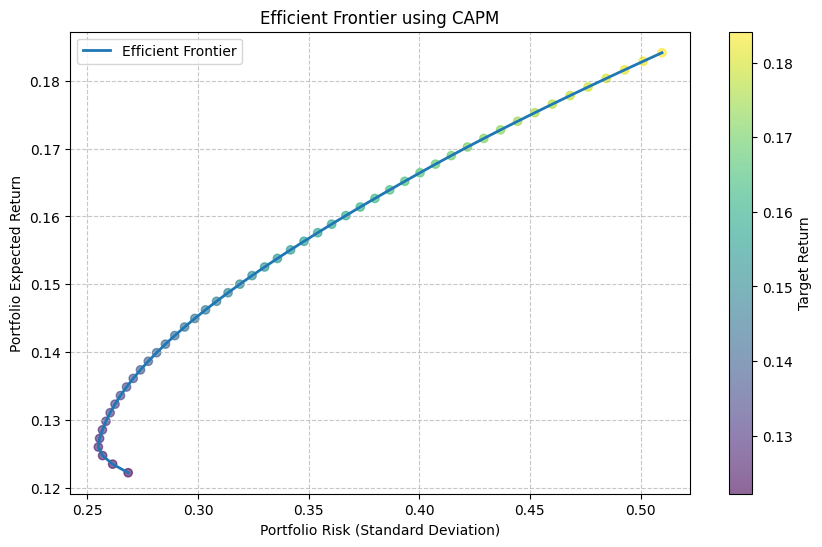


📌 Optimal Portfolio Weights for Target Return of 10.0%:
   Visa_IDR: 100.00%
   Apple_IDR: 0.00%
   NVDA_IDR: 0.00%


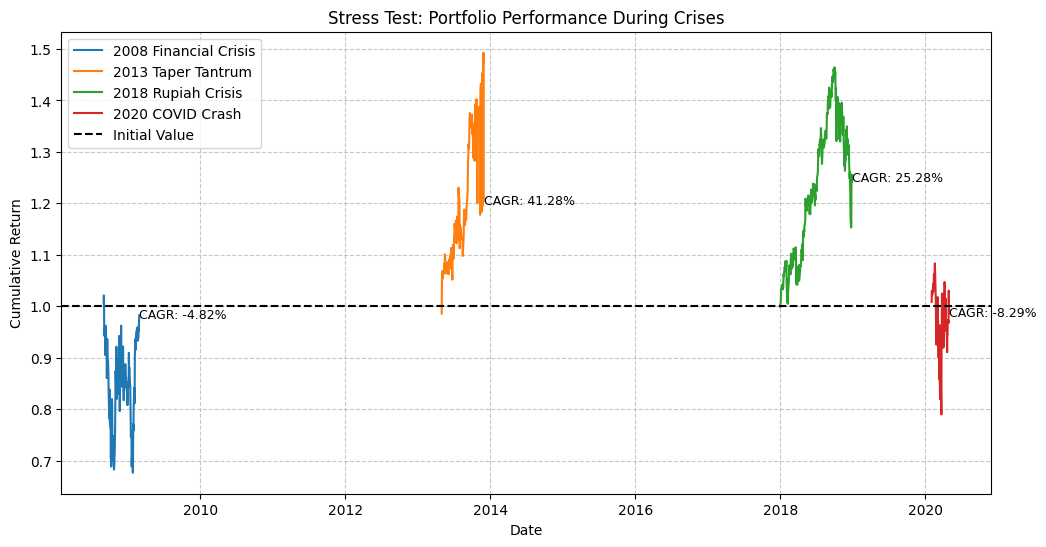

time: 1.38 s (started: 2025-03-11 06:58:50 +00:00)


In [222]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

# Assume `df` is your clean DataFrame for optimization
# Assume `data` is your long-ranging DataFrame for stress-testing

# Calculate daily returns for both `df` and `data`
returns_df = df.pct_change().dropna()  # Clean data for optimization
returns_data = data.pct_change().dropna()  # Long-ranging data for stress-testing

# Download market data (e.g., S&P 500 as the market index)
market_ticker = '^GSPC'  # S&P 500 index
market_data = yf.download(market_ticker, start=df.index.min(), end=df.index.max())['Close']
market_returns = market_data.pct_change().dropna()

# Align market_returns with returns_df
aligned_returns = returns_df.copy()
aligned_returns['Market'] = market_returns

# Drop rows with missing values
aligned_returns = aligned_returns.dropna()

# Re-extract aligned market_returns and asset returns
market_returns_aligned = aligned_returns['Market']
asset_returns_aligned = aligned_returns.drop(columns=['Market'])

# Calculate beta for each asset in `df`
def calculate_beta(asset_returns, market_returns):
    covariance = np.cov(asset_returns, market_returns)[0, 1]
    market_variance = np.var(market_returns)
    return covariance / market_variance

betas = asset_returns_aligned.apply(lambda x: calculate_beta(x, market_returns_aligned))

# Calculate expected returns using CAPM
risk_free_rate = 0.03  # Assume 3% annual risk-free rate
market_return_annual = market_returns_aligned.mean() * 252  # Annualized market return

def capm_expected_return(beta, market_return, risk_free_rate):
    return risk_free_rate + beta * (market_return - risk_free_rate)

expected_returns = betas.apply(lambda x: capm_expected_return(x, market_return_annual, risk_free_rate))

# Portfolio optimization (minimize risk for a given target return)
def portfolio_risk(weights, cov_matrix):
    return np.sqrt(weights.T @ cov_matrix @ weights)

def optimize_portfolio(expected_returns, cov_matrix, target_return):
    num_assets = len(expected_returns)
    args = (cov_matrix,)
    constraints = (
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Weights sum to 1
        {'type': 'eq', 'fun': lambda weights: np.sum(weights * expected_returns) - target_return}  # Target return
    )
    bounds = tuple((0, 1) for _ in range(num_assets))  # No short selling
    initial_guess = np.ones(num_assets) / num_assets  # Equal weights as initial guess

    result = minimize(portfolio_risk, initial_guess, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Calculate covariance matrix for `df`
cov_matrix = asset_returns_aligned.cov() * 252  # Annualized covariance matrix

# Optimize portfolio for a range of target returns
target_returns = np.linspace(expected_returns.min(), expected_returns.max(), 50)
optimal_weights_capm = []
optimal_risks = []

for target in target_returns:
    weights = optimize_portfolio(expected_returns, cov_matrix, target)
    optimal_weights_capm.append(weights)
    optimal_risks.append(portfolio_risk(weights, cov_matrix))

# Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.plot(optimal_risks, target_returns, label='Efficient Frontier', linewidth=2)
plt.scatter(optimal_risks, target_returns, c=target_returns, cmap='viridis', alpha=0.6)
plt.colorbar(label='Target Return')
plt.xlabel('Portfolio Risk (Standard Deviation)')
plt.ylabel('Portfolio Expected Return')
plt.title('Efficient Frontier using CAPM')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Display optimal portfolio for a specific target return
target_return = 0.10  # Example target return (12%)
optimal_weights_capm = optimize_portfolio(expected_returns, cov_matrix, target_return)
print(f"\n📌 Optimal Portfolio Weights for Target Return of {target_return*100}%:")
for asset, weight in zip(asset_returns_aligned.columns, optimal_weights_capm):
    print(f"   {asset}: {weight:.2%}")

# Use `data` for stress-testing
# Calculate portfolio returns for the long-ranging data
portfolio_returns_data = returns_data.dot(optimal_weights_capm)

# Define crisis periods for stress-testing
crisis_periods = {
    "2008 Financial Crisis": ('2008-09-01', '2009-03-01'),
    "2013 Taper Tantrum": ('2013-05-01', '2013-12-01'),
    "2018 Rupiah Crisis": ('2018-01-01', '2018-12-31'),
    "2020 COVID Crash": ('2020-02-01', '2020-05-01')
}

# Stress-test the portfolio during crisis periods
plt.figure(figsize=(12, 6))
for crisis, (start, end) in crisis_periods.items():
    crisis_data = portfolio_returns_data.loc[start:end]
    if not crisis_data.empty:
        cumulative_returns = (1 + crisis_data).cumprod()
        plt.plot(cumulative_returns.index, cumulative_returns, label=crisis)
        begin_value = cumulative_returns.iloc[0]
        end_value = cumulative_returns.iloc[-1]
        num_years = (crisis_data.index[-1] - crisis_data.index[0]).days / 365.25
        cagr = (end_value / begin_value) ** (1 / num_years) - 1
        plt.text(cumulative_returns.index[-1], end_value, f'CAGR: {cagr:.2%}', fontsize=9, verticalalignment='center')

plt.axhline(y=1, color='black', linestyle='--', label="Initial Value")
plt.legend()
plt.title("Stress Test: Portfolio Performance During Crises")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Backtesting porto

In [223]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# 🟢 1. AMBIL DATA HISTORIS 10 TAHUN TERAKHIR
ihsg = yf.download('^JKSE', start='2005-01-01', end='2025-03-10')['Close']
ihsg = ihsg.reindex(data.index).fillna(method='ffill')  # Sesuaikan dengan indeks `data`

new_data = data.copy()  # Data is full data ranging from 2005 to 2025
new_data['IHSG'] = ihsg
new_data = new_data.loc['2005-06-01':]  # Hanya ambil 3 tahun terakhir

returns = new_data.pct_change().dropna()

# 🟢 2. BACKTEST PORTOFOLIO
# Backtest function
def backtest_portfolio(weights, returns, start_date, end_date):
    if start_date == end_date:
        print(f"\n⚠️  Skipping {start_date} - {end_date}: Start date and end date are the same!")
        return

    selected_returns = returns.loc[start_date:end_date]

    if selected_returns.empty:
        print(f"\n⚠️  Skipping {start_date} - {end_date}: No data available!")
        return

    # Dynamically extract asset columns (exclude 'IHSG')
    asset_columns = [col for col in selected_returns.columns if col != 'IHSG']

    # Ensure weights align with the available assets
    if len(weights) != len(asset_columns):
        print(f"\n⚠️  Weights length ({len(weights)}) does not match available assets ({len(asset_columns)})!")
        return

    # Calculate portfolio returns
    portfolio_returns = (selected_returns[asset_columns] @ weights).to_frame("Portfolio Return")
    cumulative_returns = (1 + portfolio_returns).cumprod()

    # Benchmark returns (include all assets and IHSG for comparison)
    benchmark_returns = selected_returns[['IHSG'] + asset_columns]
    benchmark_cumulative = (1 + benchmark_returns).cumprod()

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_returns, label='Optimal Portfolio', linewidth=2, color='black')
    plt.plot(benchmark_cumulative, linestyle='dashed')
    plt.legend(['Optimal Portfolio'] + benchmark_returns.columns.tolist())
    plt.xlabel('Year')
    plt.ylabel('Cumulative Return')
    plt.title(f'Backtest {start_date} - {end_date}')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # Calculate performance metrics
    risk_free_rate = 0.03 / 252
    excess_returns = portfolio_returns - risk_free_rate
    sharpe_ratio = excess_returns.mean() / portfolio_returns.std() * np.sqrt(252)

    if len(cumulative_returns) > 1:
        cagr = (cumulative_returns.iloc[-1] / cumulative_returns.iloc[0])**(1/(len(selected_returns)/252)) - 1
        max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()

        print(f"\n📌 Hasil Backtest ({start_date} - {end_date}):")
        print(f"   CAGR: {cagr.iloc[0]:.2%}")
        print(f"   Sharpe Ratio: {sharpe_ratio.iloc[0]:.2f}")
        print(f"   Max Drawdown: {max_drawdown.iloc[0]:.2%}")
    else:
        print(f"\n⚠️  Not enough data for {start_date} - {end_date} to calculate CAGR/Drawdown!")




[*********************100%***********************]  1 of 1 completed

time: 71 ms (started: 2025-03-11 06:58:52 +00:00)



<ipython-input-223-831c3fc1047c>:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ihsg = ihsg.reindex(data.index).fillna(method='ffill')  # Sesuaikan dengan indeks `data`


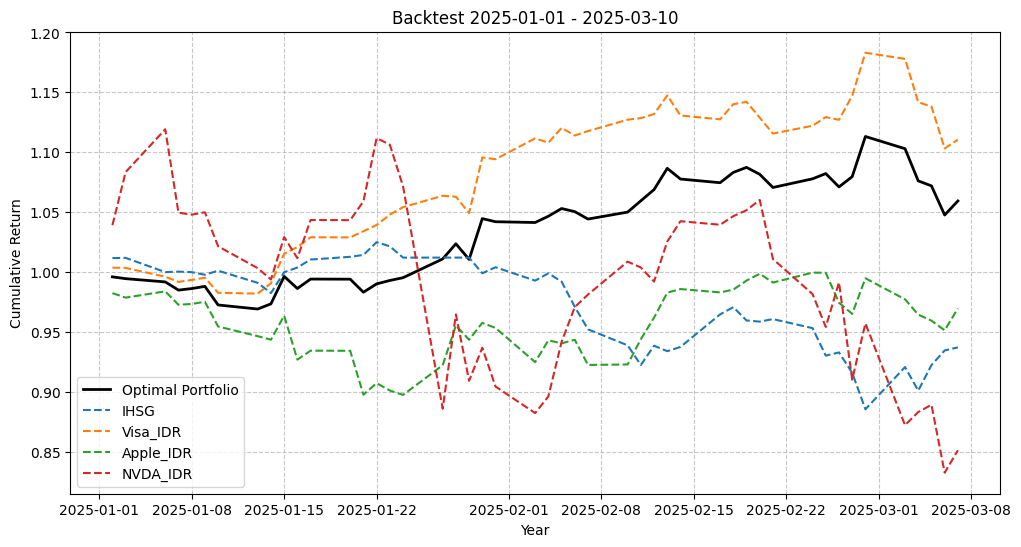


📌 Hasil Backtest (2025-01-01 - 2025-03-10):
   CAGR: 39.15%
   Sharpe Ratio: 1.60
   Max Drawdown: -5.88%


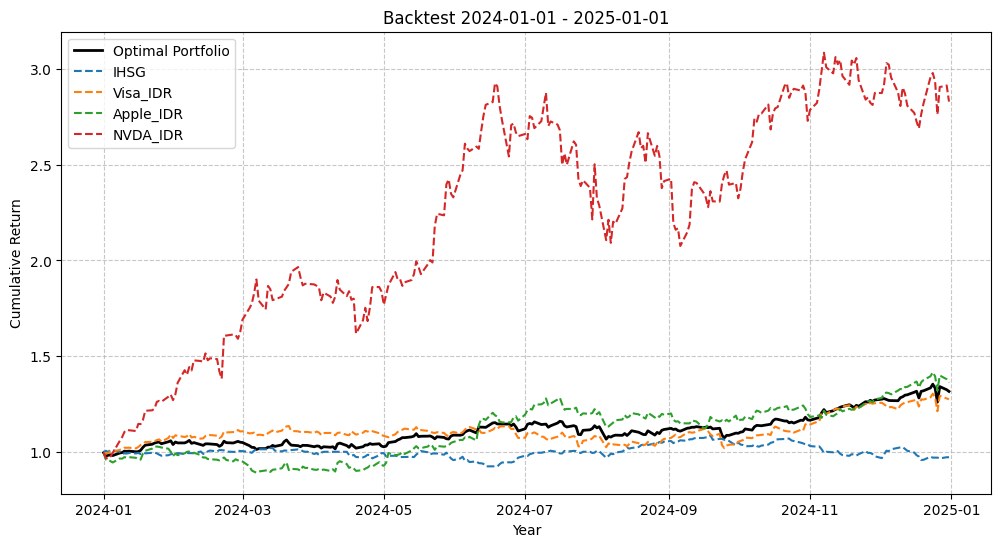


📌 Hasil Backtest (2024-01-01 - 2025-01-01):
   CAGR: 30.64%
   Sharpe Ratio: 1.39
   Max Drawdown: -8.03%

⚠️  Skipping 2024-01-01 - 2024-01-01: Start date and end date are the same!


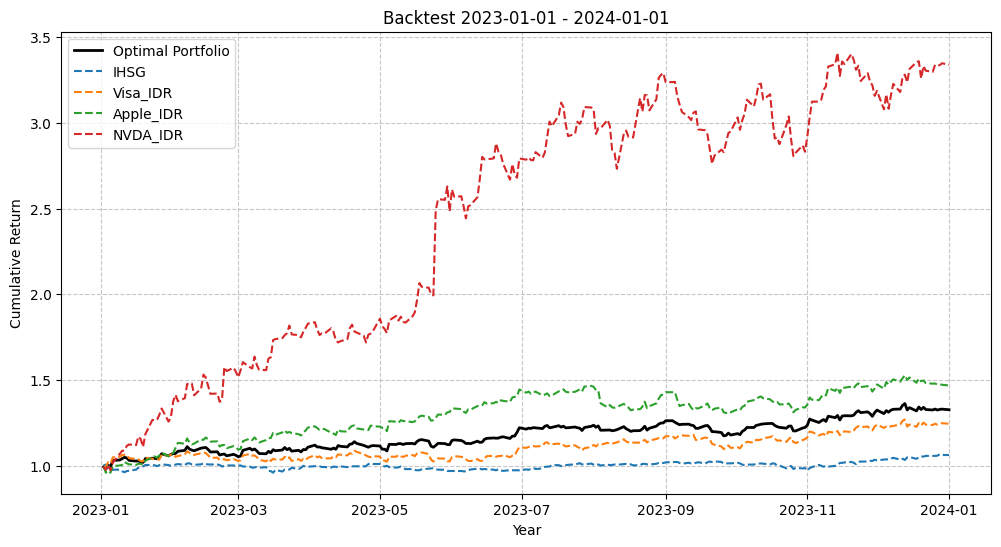


📌 Hasil Backtest (2023-01-01 - 2024-01-01):
   CAGR: 32.20%
   Sharpe Ratio: 1.57
   Max Drawdown: -7.00%


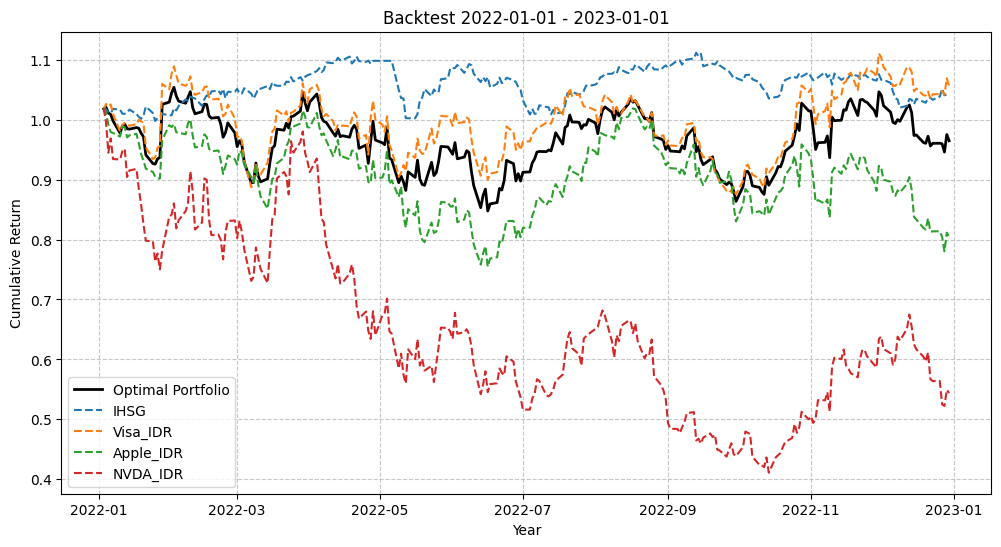


📌 Hasil Backtest (2022-01-01 - 2023-01-01):
   CAGR: -5.05%
   Sharpe Ratio: -0.06
   Max Drawdown: -19.59%

⚠️  Skipping 2022-01-01 - 2022-01-01: Start date and end date are the same!


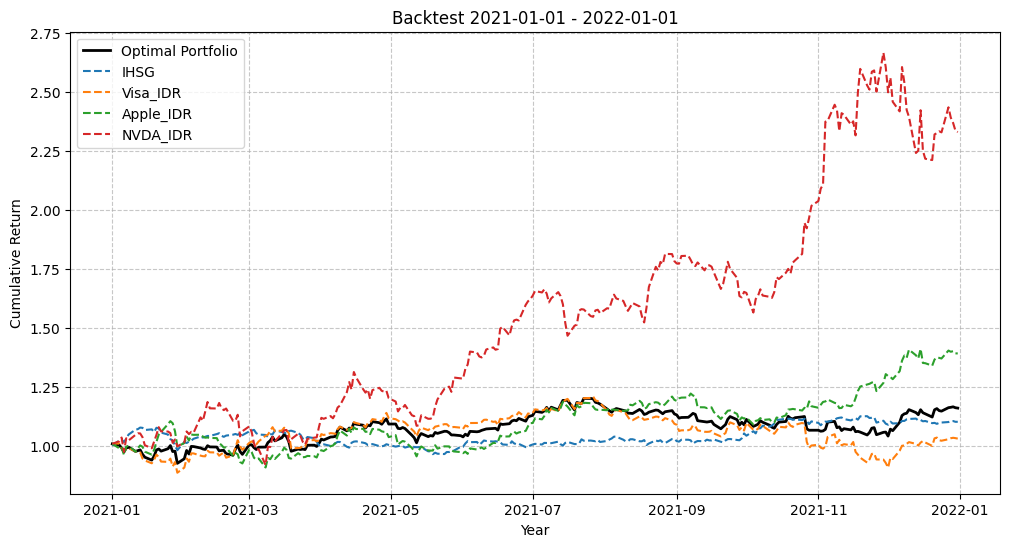


📌 Hasil Backtest (2021-01-01 - 2022-01-01):
   CAGR: 14.50%
   Sharpe Ratio: 0.63
   Max Drawdown: -13.30%


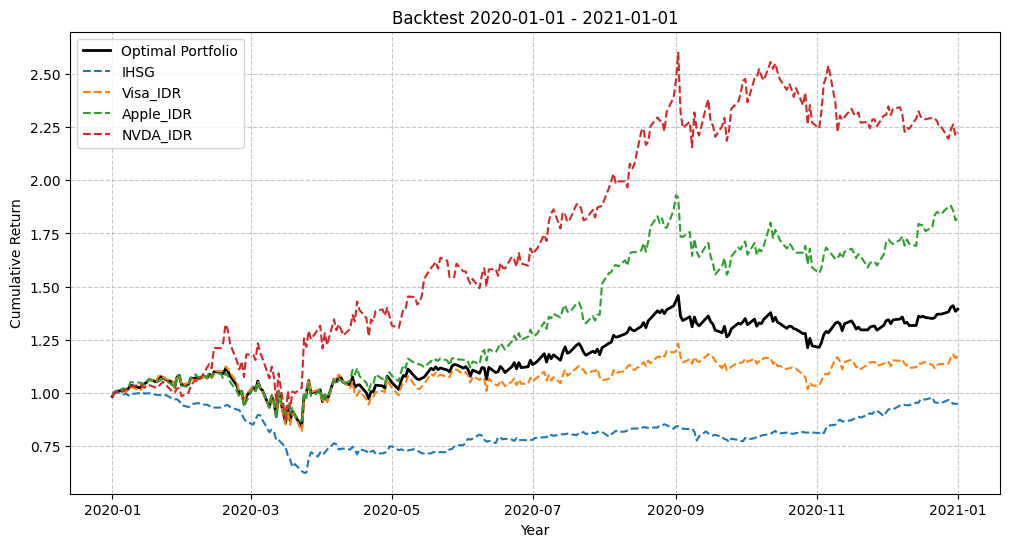


📌 Hasil Backtest (2020-01-01 - 2021-01-01):
   CAGR: 39.68%
   Sharpe Ratio: 0.85
   Max Drawdown: -24.74%


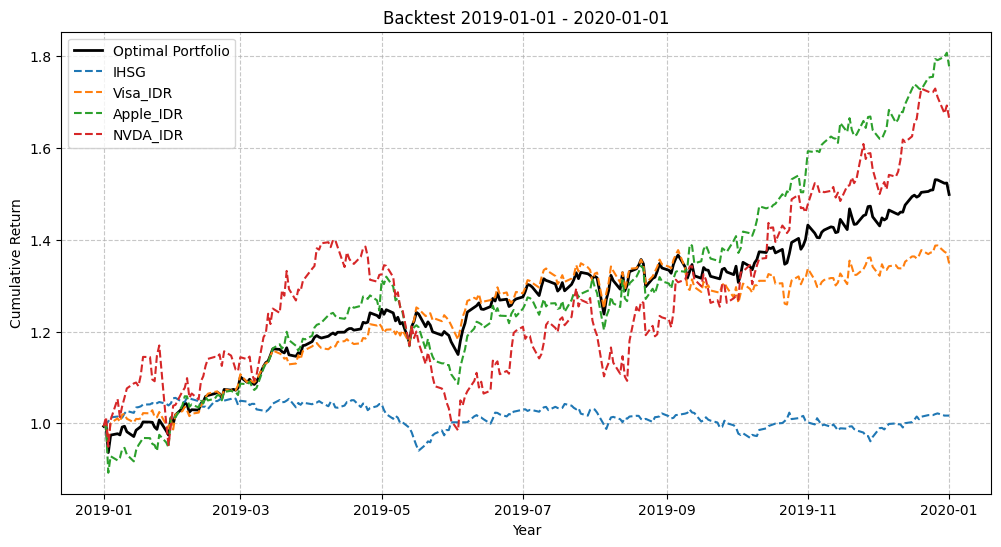


📌 Hasil Backtest (2019-01-01 - 2020-01-01):
   CAGR: 48.46%
   Sharpe Ratio: 1.85
   Max Drawdown: -7.89%

⚠️  Skipping 2019-01-01 - 2019-01-01: Start date and end date are the same!


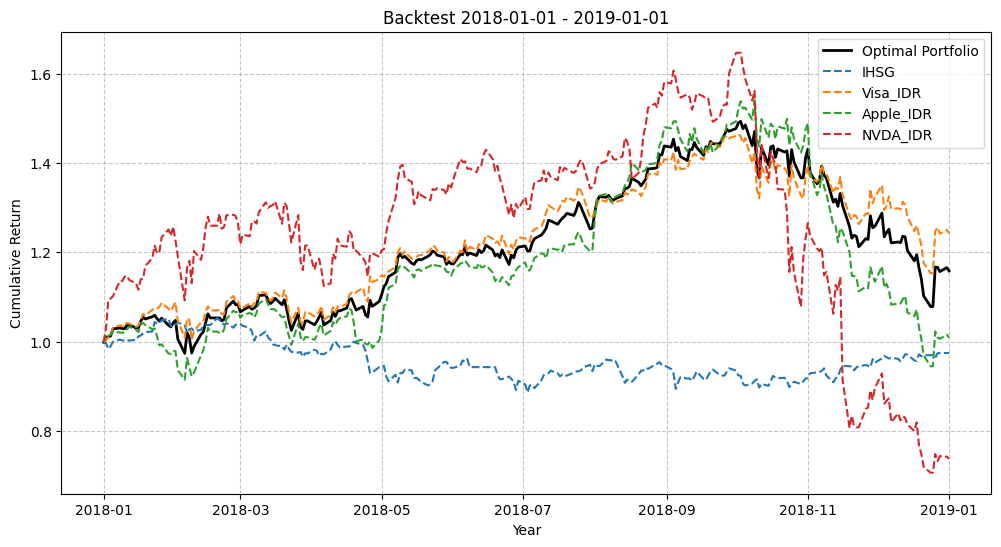


📌 Hasil Backtest (2018-01-01 - 2019-01-01):
   CAGR: 15.32%
   Sharpe Ratio: 0.56
   Max Drawdown: -27.76%


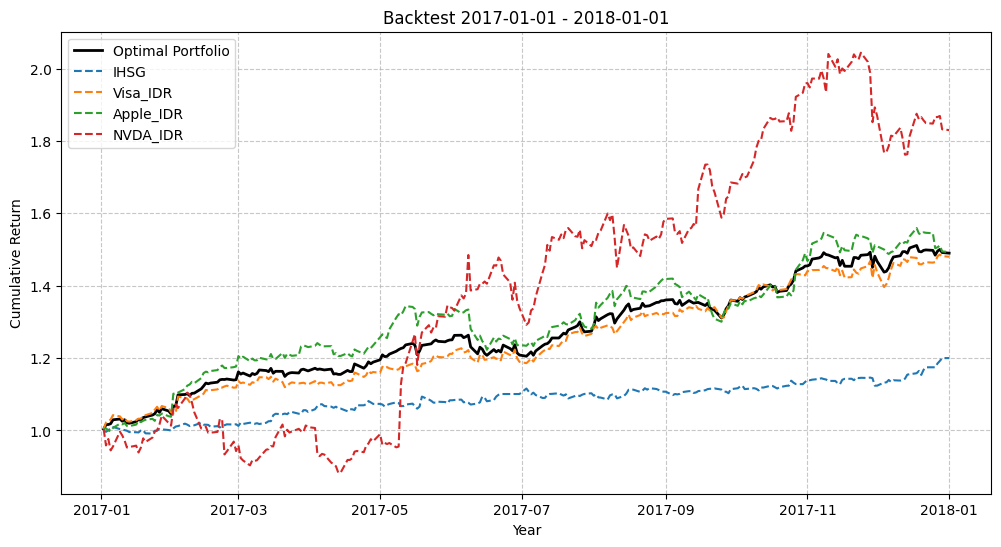


📌 Hasil Backtest (2017-01-01 - 2018-01-01):
   CAGR: 46.48%
   Sharpe Ratio: 2.92
   Max Drawdown: -4.61%


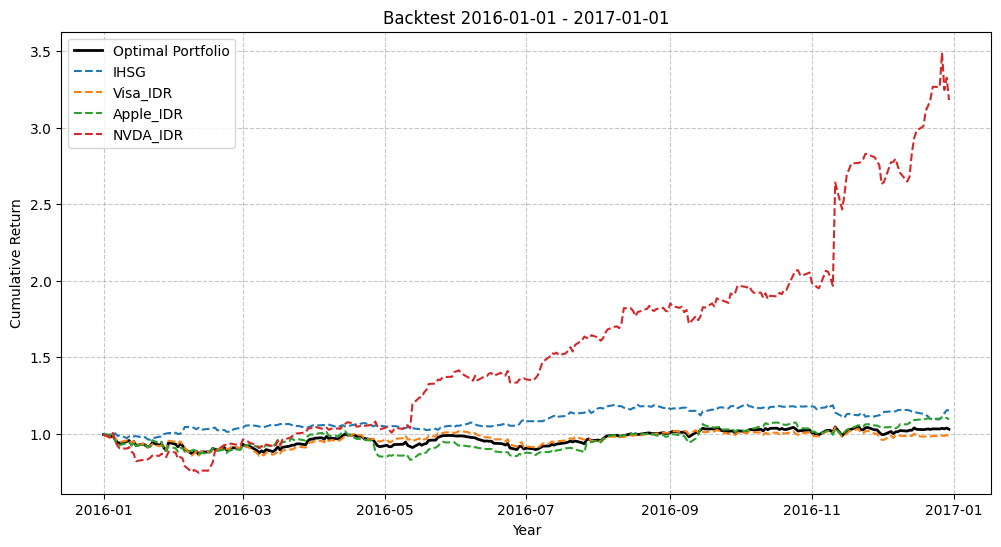


📌 Hasil Backtest (2016-01-01 - 2017-01-01):
   CAGR: 3.43%
   Sharpe Ratio: 0.10
   Max Drawdown: -13.18%

⚠️  Skipping 2016-01-01 - 2016-01-01: Start date and end date are the same!


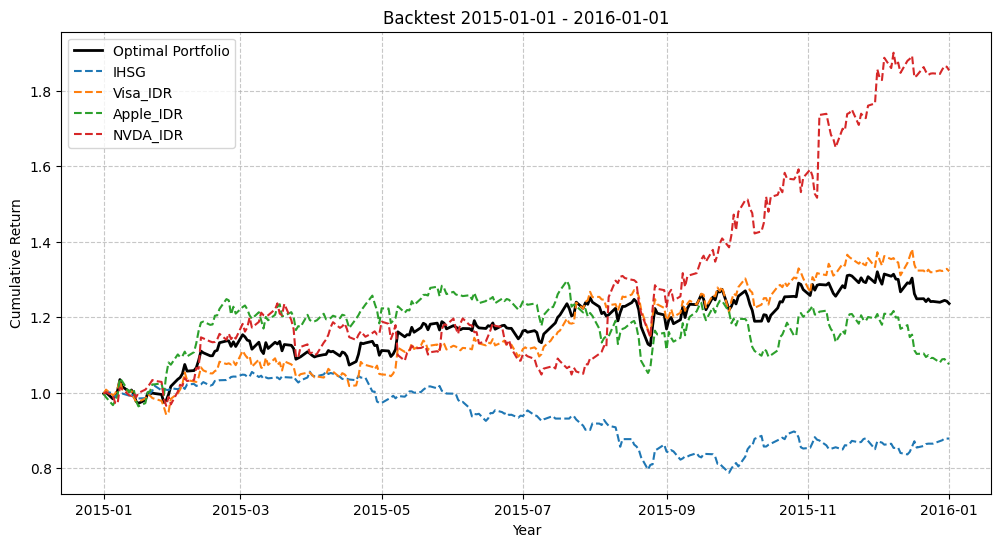


📌 Hasil Backtest (2015-01-01 - 2016-01-01):
   CAGR: 22.91%
   Sharpe Ratio: 0.89
   Max Drawdown: -10.14%


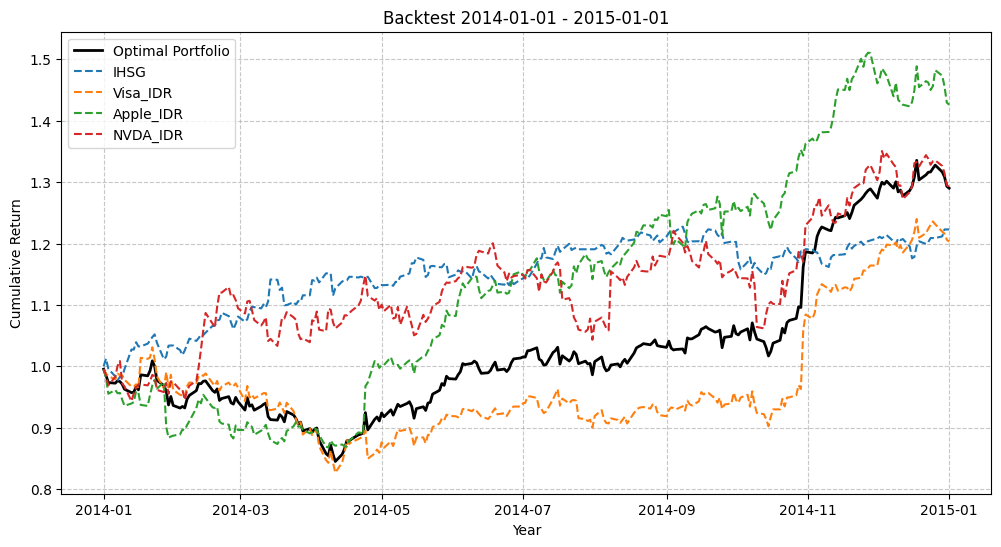


📌 Hasil Backtest (2014-01-01 - 2015-01-01):
   CAGR: 28.36%
   Sharpe Ratio: 1.30
   Max Drawdown: -16.25%


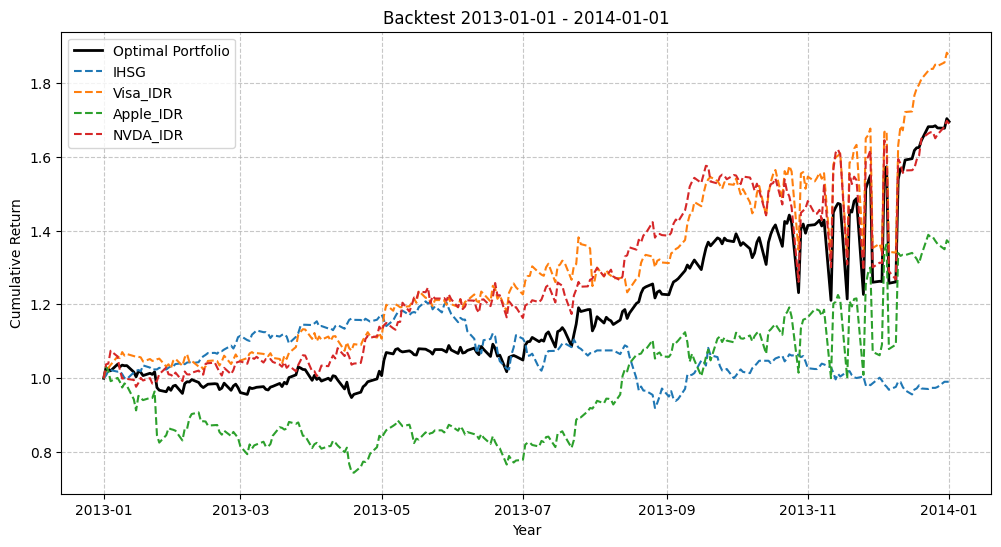


📌 Hasil Backtest (2013-01-01 - 2014-01-01):
   CAGR: 66.18%
   Sharpe Ratio: 1.03
   Max Drawdown: -20.07%

⚠️  Skipping 2013-01-01 - 2013-01-01: Start date and end date are the same!


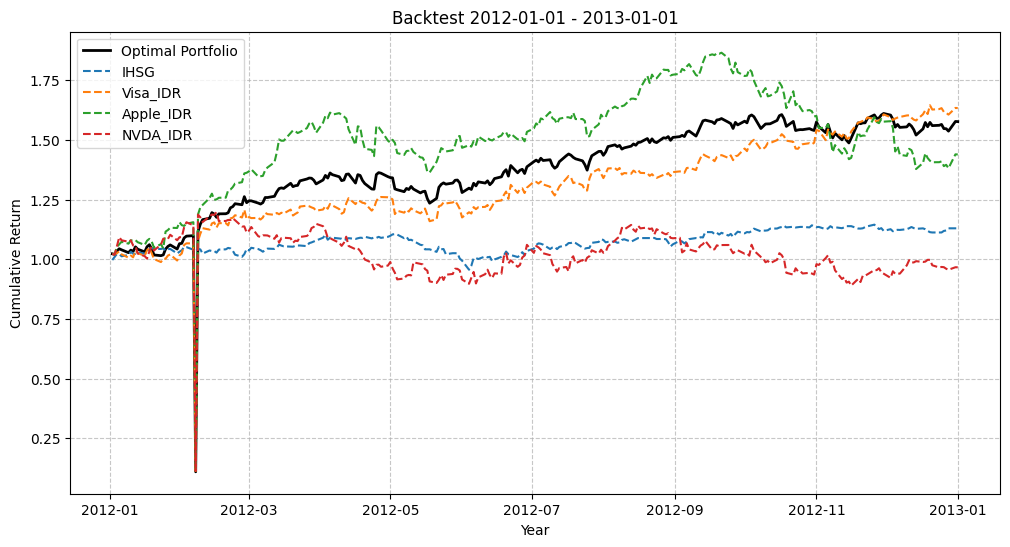


📌 Hasil Backtest (2012-01-01 - 2013-01-01):
   CAGR: 51.61%
   Sharpe Ratio: 0.93
   Max Drawdown: -89.99%


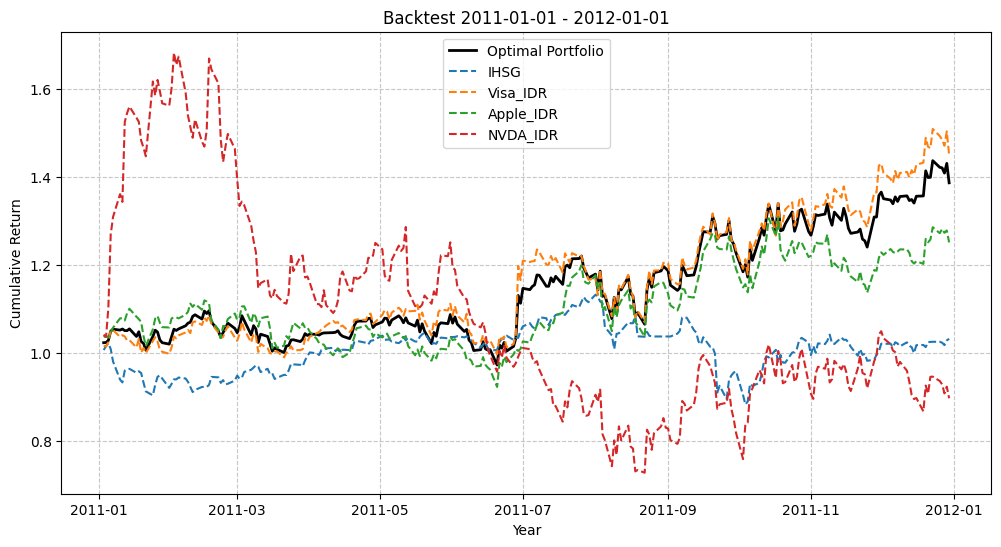


📌 Hasil Backtest (2011-01-01 - 2012-01-01):
   CAGR: 34.26%
   Sharpe Ratio: 1.06
   Max Drawdown: -12.72%


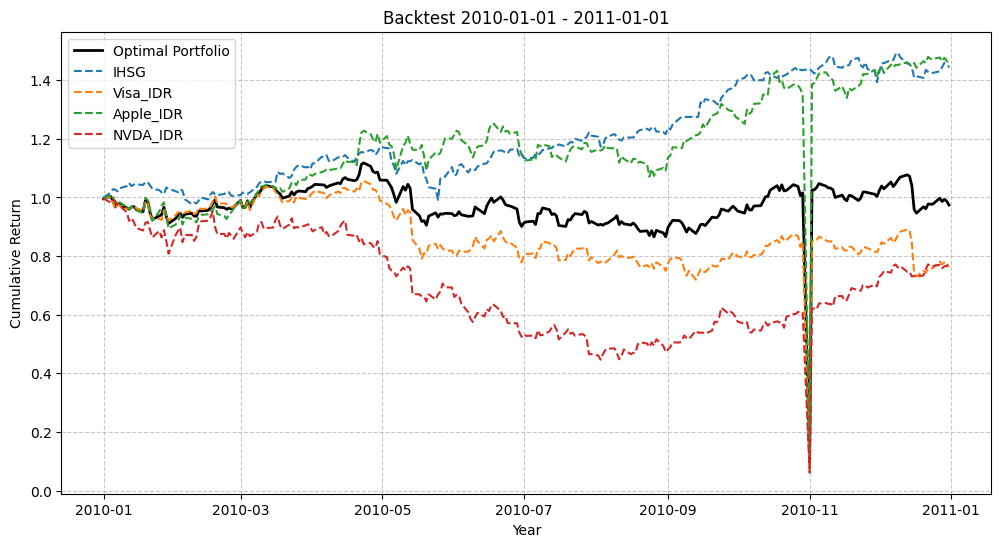


📌 Hasil Backtest (2010-01-01 - 2011-01-01):
   CAGR: -2.08%
   Sharpe Ratio: 0.88
   Max Drawdown: -90.98%
time: 5.19 s (started: 2025-03-11 06:58:52 +00:00)


In [224]:
# Define test periods
test_periods = [
    ('2024-01-01', '2025-03-10'),
    ('2022-01-01', '2024-01-01'),
    ('2019-01-01', '2022-01-01'),
    ('2016-01-01', '2019-01-01'),
    ('2013-01-01', '2016-01-01'),
    ('2010-01-01', '2013-01-01')
]

def split_into_yearly_intervals(periods):
    yearly_intervals = []
    for start, end in periods:
        start_year = int(start[:4])
        end_year = int(end[:4])

        for year in range(start_year, end_year + 1):
            interval_start = f"{year}-01-01"
            interval_end = f"{year+1}-01-01" if year < end_year else end
            yearly_intervals.append((interval_start, interval_end))

    return yearly_intervals

# Split into yearly intervals
yearly_intervals = split_into_yearly_intervals(test_periods)

# Sort intervals in descending order
yearly_intervals_sorted = sorted(yearly_intervals, key=lambda x: x[0], reverse=True)

# Run backtest for each interval
for start, end in yearly_intervals_sorted:
    backtest_portfolio(optimal_weights, returns, start, end)

In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def rolling_backtest(returns, weights, start_year, end_year, window=1):
    results = []

    # Dynamically extract asset columns (exclude 'IHSG' if it exists)
    asset_columns = [col for col in returns.columns if col != 'IHSG']

    # Ensure weights align with the available assets
    if len(weights) != len(asset_columns):
        raise ValueError(f"Weights length ({len(weights)}) does not match available assets ({len(asset_columns)})!")

    for start in range(start_year, end_year - window):  # Rolling setiap tahun
        start_date = f"{start}-01-01"
        end_date = f"{start + window}-01-01"

        # Pilih periode sesuai window
        selected_returns = returns.loc[start_date:end_date]
        if selected_returns.empty:
            continue

        # Hitung metrik backtest
        portfolio_returns = (selected_returns[asset_columns] @ weights)
        cumulative_returns = (1 + portfolio_returns).cumprod()
        risk_free_rate = 0.03 / 252  # Asumsi 3% per tahun
        excess_returns = portfolio_returns - risk_free_rate
        sharpe_ratio = excess_returns.mean() / portfolio_returns.std() * np.sqrt(252)
        cagr = (cumulative_returns.iloc[-1] / cumulative_returns.iloc[0])**(1/window) - 1
        max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()

        results.append({
            "Period": f"{start}-{start + window}",
            "CAGR": cagr,
            "Sharpe Ratio": sharpe_ratio,
            "Max Drawdown": max_drawdown
        })

    return pd.DataFrame(results)

# Example usage
# Assume `returns` is your DataFrame with asset returns and `optimal_weights` is calculated
df_results = rolling_backtest(returns, optimal_weights, 2010, 2026, window=1)
print(df_results)

       Period      CAGR  Sharpe Ratio  Max Drawdown
0   2010-2011 -0.021501      0.878031     -0.909842
1   2011-2012  0.355186      1.064258     -0.127165
2   2012-2013  0.541374      0.925429     -0.899939
3   2013-2014  0.695588      1.032749     -0.200704
4   2014-2015  0.296366      1.297870     -0.162508
5   2015-2016  0.239165      0.893330     -0.101379
6   2016-2017  0.035545      0.097625     -0.131753
7   2017-2018  0.484899      2.915154     -0.046083
8   2018-2019  0.159731      0.556584     -0.277564
9   2019-2020  0.508091      1.853215     -0.078930
10  2020-2021  0.417334      0.848880     -0.247422
11  2021-2022  0.150514      0.626885     -0.133011
12  2022-2023 -0.052088     -0.061891     -0.195926
13  2023-2024  0.335297      1.567603     -0.069963
14  2024-2025  0.320353      1.392756     -0.080325
time: 68.1 ms (started: 2025-03-11 06:58:57 +00:00)


In [226]:
optimal_weights

array([6.39029506e-01, 3.60922617e-01, 4.78770948e-05])

time: 1.99 ms (started: 2025-03-11 06:58:57 +00:00)


# Uji Stres

In [227]:
df

,Visa_IDR,Apple_IDR,NVDA_IDR
Date,,,
2015-01-01,7.559962e+05,3.042241e+05,5.962359e+03
2015-01-02,7.641272e+05,3.013301e+05,5.986148e+03
2015-01-05,7.526879e+05,2.949683e+05,5.927789e+03
2015-01-06,7.565267e+05,2.984236e+05,5.814852e+03
2015-01-07,7.672698e+05,3.028478e+05,5.804297e+03
...,...,...,...
2025-03-03,5.977990e+06,3.932732e+06,1.884499e+06
2025-03-04,5.794606e+06,3.881331e+06,1.908175e+06
2025-03-05,5.776546e+06,3.861186e+06,1.921257e+06


time: 32 ms (started: 2025-03-11 06:58:57 +00:00)


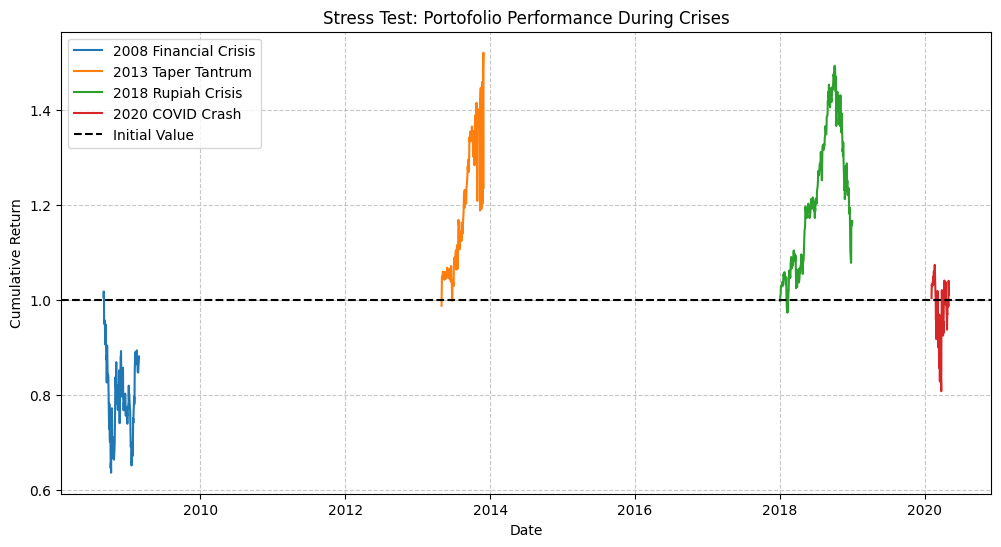

Return during 2008 Financial Crisis: -11.85%
Return during 2013 Taper Tantrum: 23.65%
Return during 2018 Rupiah Crisis: 16.58%
Return during 2020 COVID Crash: 1.21%
time: 290 ms (started: 2025-03-11 06:58:57 +00:00)


In [228]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
# Assume `data` is your DataFrame with asset prices and `optimal_weights` is calculated
# data = pd.read_csv('your_data.csv', index_col='Date', parse_dates=True)
# optimal_weights = np.array([0.4, 0.3, 0.3])  # Example weights

# Hitung return harian
returns = data.pct_change().dropna()

# Dynamically extract asset columns (exclude 'IHSG' if it exists)
asset_columns = [col for col in returns.columns if col != 'IHSG']

# Ensure weights align with the available assets
if len(optimal_weights) != len(asset_columns):
    raise ValueError(f"Weights length ({len(optimal_weights)}) does not match available assets ({len(asset_columns)})!")

# Hitung return portofolio
portfolio_returns = returns[asset_columns].dot(optimal_weights)

# Periode krisis besar
crisis_periods = {
    "2008 Financial Crisis": ('2008-09-01', '2009-03-01'),
    "2013 Taper Tantrum": ('2013-05-01', '2013-12-01'),
    "2018 Rupiah Crisis": ('2018-01-01', '2018-12-31'),
    "2020 COVID Crash": ('2020-02-01', '2020-05-01')
}

# Visualisasi performa portofolio saat krisis
plt.figure(figsize=(12, 6))

for crisis, (start, end) in crisis_periods.items():
    crisis_data = portfolio_returns.loc[start:end]
    plt.plot(crisis_data.index, (1 + crisis_data).cumprod(), label=crisis)

plt.axhline(y=1, color='black', linestyle='--', label="Initial Value")
plt.legend()
plt.title("Stress Test: Portofolio Performance During Crises")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Menampilkan return selama krisis
for crisis, (start, end) in crisis_periods.items():
    crisis_return = (1 + portfolio_returns.loc[start:end]).cumprod().iloc[-1] - 1
    print(f"Return during {crisis}: {crisis_return:.2%}")

2008 Financial Crisis: CAGR = -23.71%
2013 Taper Tantrum: CAGR = 47.14%
2018 Rupiah Crisis: CAGR = 16.78%
2020 COVID Crash: CAGR = 3.33%


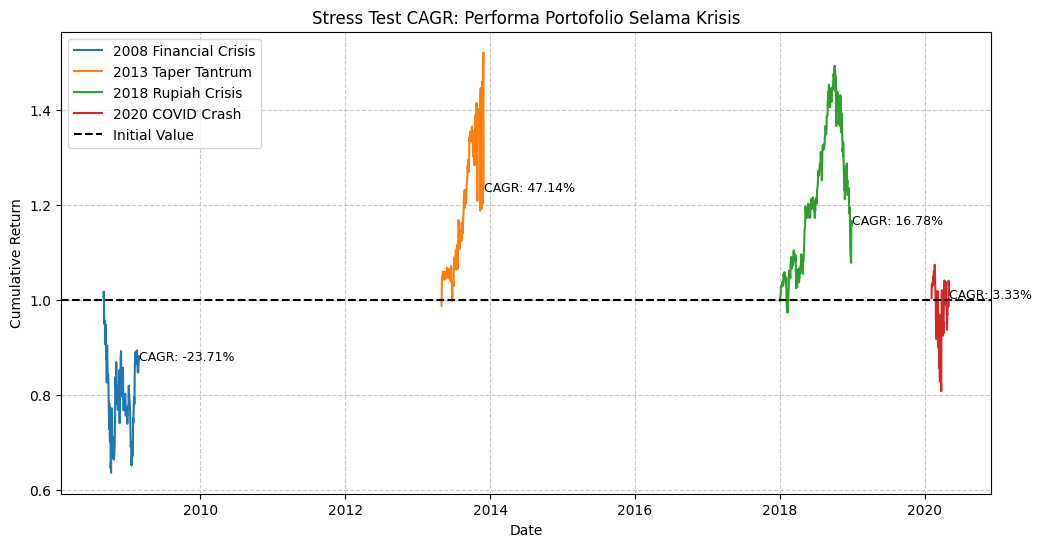

time: 334 ms (started: 2025-03-11 06:58:58 +00:00)


In [229]:
# Hitung return harian
returns = data.pct_change().dropna()

# Dynamically extract asset columns (exclude 'IHSG' if it exists)
asset_columns = [col for col in returns.columns if col != 'IHSG']

# Ensure weights align with the available assets
if len(optimal_weights) != len(asset_columns):
    raise ValueError(f"Weights length ({len(optimal_weights)}) does not match available assets ({len(asset_columns)})!")

# Hitung return portofolio
portfolio_returns = returns[asset_columns].dot(optimal_weights)

# Periode krisis besar
crisis_periods = {
    "2008 Financial Crisis": ('2008-09-01', '2009-03-01'),
    "2013 Taper Tantrum": ('2013-05-01', '2013-12-01'),
    "2018 Rupiah Crisis": ('2018-01-01', '2018-12-31'),
    "2020 COVID Crash": ('2020-02-01', '2020-05-01')
}

# Fungsi untuk menghitung CAGR
def calculate_cagr(begin_value, end_value, periods):
    return (end_value / begin_value) ** (1 / periods) - 1

# Hitung dan tampilkan CAGR untuk setiap periode krisis
for crisis, (start, end) in crisis_periods.items():
    crisis_data = portfolio_returns.loc[start:end]
    if not crisis_data.empty:
        cumulative_returns = (1 + crisis_data).cumprod()
        begin_value = cumulative_returns.iloc[0]
        end_value = cumulative_returns.iloc[-1]
        num_years = (crisis_data.index[-1] - crisis_data.index[0]).days / 365.25
        cagr = calculate_cagr(begin_value, end_value, num_years)
        print(f"{crisis}: CAGR = {cagr:.2%}")
    else:
        print(f"{crisis}: No data available for this period.")

# Plot performa portofolio selama krisis
plt.figure(figsize=(12, 6))

for crisis, (start, end) in crisis_periods.items():
    crisis_data = portfolio_returns.loc[start:end]
    if not crisis_data.empty:
        cumulative_returns = (1 + crisis_data).cumprod()
        plt.plot(cumulative_returns.index, cumulative_returns, label=crisis)
        begin_value = cumulative_returns.iloc[0]
        end_value = cumulative_returns.iloc[-1]
        num_years = (cumulative_returns.index[-1] - cumulative_returns.index[0]).days / 365.25
        cagr = calculate_cagr(begin_value, end_value, num_years)
        plt.text(cumulative_returns.index[-1], end_value, f'CAGR: {cagr:.2%}', fontsize=9, verticalalignment='center')

plt.axhline(y=1, color='black', linestyle='--', label="Initial Value")
plt.legend()
plt.title("Stress Test CAGR: Performa Portofolio Selama Krisis")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# CVar Risk Analysis

Ini adalah rumus inline: $E = mc^2$


### **Definisi, Maksud, dan Tujuan CVaR (Conditional Value at Risk)**  

#### **📌 Definisi CVaR**  
Conditional Value at Risk (CVaR), juga disebut **Expected Shortfall (ES)**, adalah ukuran risiko yang menghitung **kerugian rata-rata** dalam skenario ekstrem yang berada di luar ambang batas Value at Risk (VaR).  

Matematis, jika kita memiliki tingkat kepercayaan $\alpha$ (misalnya 95%), maka:  


$\text{CVaR}_\alpha = \mathbb{E} [ X | X \leq \text{VaR}_\alpha ]$


Artinya, CVaR adalah **rata-rata kerugian yang lebih besar dari VaR**.


---

#### **🎯 Maksud CVaR**  
CVaR memperbaiki kelemahan VaR, karena:  
✅ **Menangkap tail risk** – VaR hanya menunjukkan batas kerugian tanpa memperhitungkan seberapa parah kerugian yang mungkin terjadi.  
✅ **Lebih stabil dibanding VaR** – CVaR tidak rentan terhadap perubahan kecil dalam distribusi return.  
✅ **Cocok untuk skenario Black Swan** – CVaR dapat menangkap kerugian ekstrem dalam distribusi return yang heavy-tailed (seperti distribusi Student’s T).  

---

#### **🏆 Tujuan CVaR**  
1️⃣ **Mengukur risiko ekstrem dengan lebih akurat dibandingkan VaR.**  
2️⃣ **Digunakan dalam manajemen risiko keuangan** untuk menghindari kejutan besar dalam portofolio investasi.  
3️⃣ **Membantu strategi alokasi aset** agar lebih tahan terhadap skenario pasar yang buruk.  

---

#### **🛠️ Kesimpulan**  
CVaR lebih baik dibandingkan VaR karena **tidak hanya memberi tahu batas kerugian (VaR), tetapi juga berapa besar rata-rata kerugian di skenario terburuk**. Oleh karena itu, **lebih direkomendasikan untuk analisis risiko di pasar keuangan yang rentan terhadap krisis**. 🚀

In [230]:
import numpy as np
import scipy.stats as stats

# Parameter simulasi
np.random.seed(42)
n_simulations = 50000
alpha = 0.1  # Confidence level 90%

# Distribusi Student's T
nu = 2  # Degree of freedom
simulated_returns_t = stats.t.rvs(df=nu, size=n_simulations)

# Distribusi Normal untuk perbandingan
simulated_returns_norm = np.random.normal(size=n_simulations)

# Hitung Value at Risk (VaR)
VaR_t = np.percentile(simulated_returns_t, 100 * alpha)
VaR_norm = np.percentile(simulated_returns_norm, 100 * alpha)

# Hitung Conditional Value at Risk (CVaR)
CVaR_t = simulated_returns_t[simulated_returns_t <= VaR_t].mean()
CVaR_norm = simulated_returns_norm[simulated_returns_norm <= VaR_norm].mean()

print(f"VaR (Student's T, alpha={alpha}): {VaR_t:.4f}")
print(f"VaR (Normal, alpha={alpha}): {VaR_norm:.4f}")
print(f"CVaR (Student's T, alpha={alpha}): {CVaR_t:.4f}")
print(f"CVaR (Normal, alpha={alpha}): {CVaR_norm:.4f}")


VaR (Student's T, alpha=0.1): -1.8604
VaR (Normal, alpha=0.1): -1.2772
CVaR (Student's T, alpha=0.1): -4.1333
CVaR (Normal, alpha=0.1): -1.7536
time: 13.7 ms (started: 2025-03-11 06:58:58 +00:00)


In [231]:
import numpy as np
import scipy.stats as stats

# Parameter simulasi
np.random.seed(42)
n_simulations = 5000
alpha = 0.1  # Confidence level 90%
nu = 2  # Degree of freedom for Student's T distribution

# Hitung return log harian dari data historis
returns = np.log(df / df.shift(1)).dropna()

# Hitung return portofolio harian berdasarkan bobot optimal
portfolio_returns = returns @ optimal_weights

# Simulasi Monte Carlo berdasarkan distribusi Student's T dan Normal
simulated_returns_t = stats.t.rvs(df=nu, size=n_simulations) * portfolio_returns.std() + portfolio_returns.mean()
simulated_returns_norm = np.random.normal(loc=portfolio_returns.mean(), scale=portfolio_returns.std(), size=n_simulations)

# Hitung Value at Risk (VaR)
VaR_hist = np.percentile(portfolio_returns, 100 * alpha)
VaR_t = np.percentile(simulated_returns_t, 100 * alpha)
VaR_norm = np.percentile(simulated_returns_norm, 100 * alpha)

# Hitung Conditional Value at Risk (CVaR)
CVaR_hist = portfolio_returns[portfolio_returns <= VaR_hist].mean()
CVaR_t = simulated_returns_t[simulated_returns_t <= VaR_t].mean()
CVaR_norm = simulated_returns_norm[simulated_returns_norm <= VaR_norm].mean()

# Hasil
print(f"VaR (Historical, alpha={alpha}): {VaR_hist:.4f}")
print(f"VaR (Student's T, alpha={alpha}): {VaR_t:.4f}")
print(f"VaR (Normal, alpha={alpha}): {VaR_norm:.4f}")
print(f"CVaR (Historical, alpha={alpha}): {CVaR_hist:.4f}")
print(f"CVaR (Student's T, alpha={alpha}): {CVaR_t:.4f}")
print(f"CVaR (Normal, alpha={alpha}): {CVaR_norm:.4f}")

VaR (Historical, alpha=0.1): -0.0155
VaR (Student's T, alpha=0.1): -0.0283
VaR (Normal, alpha=0.1): -0.0191
CVaR (Historical, alpha=0.1): -0.0276
CVaR (Student's T, alpha=0.1): -0.0731
CVaR (Normal, alpha=0.1): -0.0265
time: 13.6 ms (started: 2025-03-11 06:58:58 +00:00)


In [232]:
# Hitung return portofolio harian
portfolio_returns = returns.dot(optimal_weights)

# Parameter simulasi
np.random.seed(42)
n_simulations = 50000
alpha = 0.1  # Confidence level 90%

# Distribusi Student's T
nu = 2  # Degree of freedom
mean_portfolio_return = portfolio_returns.mean()
std_portfolio_return = portfolio_returns.std()

# Simulasikan return portofolio menggunakan distribusi Student's T
simulated_returns_t = mean_portfolio_return + std_portfolio_return * stats.t.rvs(df=nu, size=n_simulations)

# Distribusi Normal untuk perbandingan
simulated_returns_norm = np.random.normal(loc=mean_portfolio_return, scale=std_portfolio_return, size=n_simulations)

# Hitung Value at Risk (VaR)
VaR_t = np.percentile(simulated_returns_t, 100 * alpha)
VaR_norm = np.percentile(simulated_returns_norm, 100 * alpha)

# Hitung Conditional Value at Risk (CVaR)
CVaR_t = simulated_returns_t[simulated_returns_t <= VaR_t].mean()
CVaR_norm = simulated_returns_norm[simulated_returns_norm <= VaR_norm].mean()

print(f"VaR (Student's T, alpha={alpha}): {VaR_t:.4f}")
print(f"VaR (Normal, alpha={alpha}): {VaR_norm:.4f}")
print(f"CVaR (Student's T, alpha={alpha}): {CVaR_t:.4f}")
print(f"CVaR (Normal, alpha={alpha}): {CVaR_norm:.4f}")

VaR (Student's T, alpha=0.1): -0.0285
VaR (Normal, alpha=0.1): -0.0193
CVaR (Student's T, alpha=0.1): -0.0643
CVaR (Normal, alpha=0.1): -0.0268
time: 12.7 ms (started: 2025-03-11 06:58:58 +00:00)
